---
## Config

In [3]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import numpy as np
import sys
sys.path.append("./utils_library/")

import configs.default_config as cfg
import configs.local_storage_config as storage_cfg
cfg.__dict__.update(storage_cfg.__dict__)

from training import dataset_functions_self, callbacks, dataset_builder_self, load_weights, loss_metrics
from training.utils import now
nowt=now()

import models.mobilenet_model as model
cfg.RUN_NAME="mobilenet_model" #for reference 

---
## Dataset

In [4]:
# Training settings
TRAINING_EPOCHS = 200
REAL_EPOCH_STEPS = int(cfg.DATASET_SIZE / cfg.BATCH_SIZE) + 1
SHORT_VALIDATION_STEPS=5 #per short epoch

# adam_learning_rate=0.001  #for reference
BASE_LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDUELE = np.zeros(100000)  #used with short epochs
LEARNING_RATE_SCHEDUELE[:100] = 1
LEARNING_RATE_SCHEDUELE[100:150] = 0.1
LEARNING_RATE_SCHEDUELE[150:200] = 0.01
LEARNING_RATE_SCHEDUELE *= BASE_LEARNING_RATE

In [5]:
model_ds=model.ModelDatasetComponent(cfg)

tfrecord_files_train=dataset_builder_self.get_tfrecord_filenames(cfg.TRAIN_TFRECORDS,cfg)
tfrecord_files_valid=dataset_builder_self.get_tfrecord_filenames(cfg.VALID_TFRECORDS,cfg)
print("Found the following training TFrecords:\n","\n".join(tfrecord_files_train))
print("Found the following validation TFrecords:\n","\n".join(tfrecord_files_valid))

print("Building training dataset")
dst=dataset_builder_self.build_training_ds(tfrecord_files_train,model_ds.place_training_labels,cfg)
print("Training dataset shape:",dst)
print("Building validation dataset")
dsv=dataset_builder_self.build_validation_ds(tfrecord_files_valid,model_ds.place_training_labels,cfg)
print("Validation dataset shape:",dsv)


Retrieving TFrecords from: ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/training
Retrieving TFrecords from: ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/validation
Found the following training TFrecords:
 ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/training-001.tfrecords
Found the following validation TFrecords:
 ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/validation-001.tfrecords
Building training dataset
Training dataset shape: <PrefetchDataset shapes: (((None, 368, 765, 3), (None, 46, 96, 1)), ((None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 19), (None, 46, 96, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>
Building validation dataset
Validation dataset shape: <PrefetchDataset shapes: (((None, 368, 765, 3), (None, 46, 96, 1)), ((None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (

In [11]:
#Test element
dst_iter=iter(dst)
sample_elem=next(dst_iter)

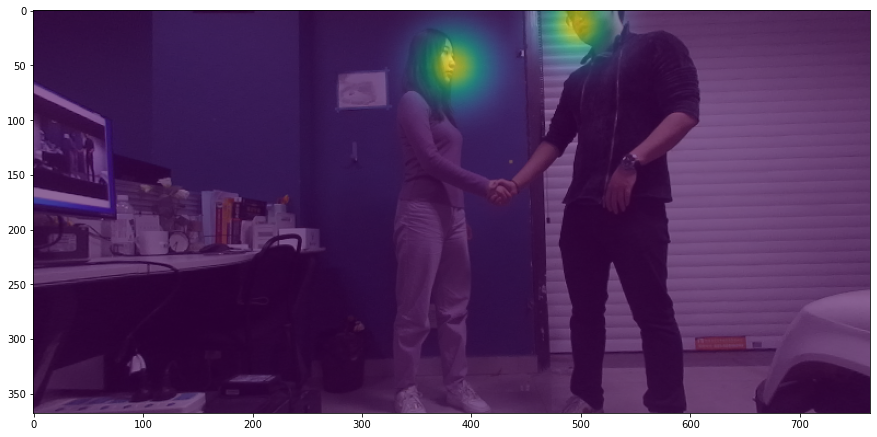

In [27]:
#testing img
img = sample_elem[0][0][0,...]
plt.figure(figsize=[15,15])
plt.imshow(img)

#testing mask
m=sample_elem[1][4][0,...,0]
m=cv2.resize(m.numpy(), dsize=(765, 368))
plt.imshow(m, alpha=0.6)

---
## Model
### Load weights

In [7]:
if cfg.ASK_FOR_CHECKPOINTS:
    checkpoint,starting_epoch=load_weights.checkpoints_prompt(cfg)
else:
    checkpoint=None
    starting_epoch=0

Found no checkpoints


### Build Model

In [8]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

model_maker=model.ModelMaker(cfg) #must be outside scope to keep the graph clean
tf.keras.backend.clear_session() #to clean to backaend from the imported model

def define():
    train_model,test_model=model_maker.create_models()   
    
    #this must match the model output order
    metrics=[
              [loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]    
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
        ]
    
    model_path = "./trained_models/mobilenet_model_COCO/"
    mobilenet_model_COCO = tf.keras.models.load_model(model_path)

    for layer in mobilenet_model_COCO.layers:
        train_layer = train_model.get_layer(layer.name)
        weights = layer.get_weights()
        train_layer.set_weights(weights)
    
    del mobilenet_model_COCO
    
    return train_model,test_model

train_model,test_model=define()

KeyboardInterrupt: 

In [ ]:
def set_trainable_layers(train_model, trainable_layers_list, train_type):
    for layer in train_model.layers:
        layer.trainable = True
    
    for layer in train_model.layers:
        if layer.name in trainable_layers_list:
            print("Set trainable layer:", layer.name)
            continue
        layer.trainable = False
    
    if train_type == 'kpt':
        train_model.compile(
                        optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE)                   
                        ,loss=loss_metrics.MaskedMeanSquaredError()
                        ,loss_weights=[0,0,0,0,0,1]                          
                       )
    
    if train_type == 'paf':
        train_model.compile(
                        optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE)                   
                        ,loss=loss_metrics.MaskedMeanSquaredError()
                        ,loss_weights=[0,0,0,1,0,0]                          
                       )
    
    return train_model

In [ ]:
#for layer in train_model.layers:
#    print(layer.name, ":", layer.trainable)

train_model.summary()

### Callbacks

In [ ]:
all_callbacks=[
    callbacks.make_LRscheduler_callback(LEARNING_RATE_SCHEDUELE)
    ,callbacks.PrintLR()
    ,tf.keras.callbacks.TerminateOnNaN()
]

if cfg.SAVE_CHECKPOINTS:
    checkpoint_callback,checkpoint_path=callbacks.make_checkpoint_callback(cfg,nowt,200*REAL_EPOCH_STEPS)
    all_callbacks.append(checkpoint_callback)
if cfg.SAVE_TENSORBOARD:
    tensorboard_callback,tensorboard_path=callbacks.make_tensorboard_callback(cfg,nowt,200*REAL_EPOCH_STEPS)
    all_callbacks+=[tensorboard_callback]

---
## Training
Actually training

In [ ]:
trainable_layers_list_paf = ['s4pafs_final_project', 's4pafs_final_project_bn', 's4pafs_finalconv']
train_model = set_trainable_layers(train_model, trainable_layers_list_paf, 'paf')

In [ ]:
train_history=train_model.fit(
    dst
    ,epochs=TRAINING_EPOCHS
    ,steps_per_epoch=REAL_EPOCH_STEPS
    ,validation_data=dsv
    ,callbacks=all_callbacks
    ,initial_epoch=starting_epoch
)

In [ ]:
trainable_layers_list_kpt = ['s6kpts_final_project', 's6kpts_final_project_bn', 's6kpts_finalconv']
train_model = set_trainable_layers(train_model, trainable_layers_list_kpt, 'kpt')

In [ ]:
train_history=train_model.fit(
    dst
    ,epochs=TRAINING_EPOCHS
    ,steps_per_epoch=REAL_EPOCH_STEPS
    ,validation_data=dsv
    ,callbacks=all_callbacks
    ,initial_epoch=starting_epoch
)

---
### Save results

In [ ]:
tmp_path='./dl_training_results/temp_weights'
train_model.save_weights(tmp_path)

local_model_maker=model.ModelMaker(cfg) #must be outside scope to keep the graph clean
tf.keras.backend.clear_session() #to clean to backaend from the imported model

cpu_train_model,cpu_test_model=local_model_maker.create_models()

cpu_train_model.load_weights(tmp_path)
cpu_test_model.load_weights(tmp_path)

cpu_test_model.save(cfg.MODELS_PATH+"/test_"+cfg.RUN_NAME+nowt,include_optimizer=False) 
cpu_train_model.save(cfg.MODELS_PATH+"/train_"+cfg.RUN_NAME+nowt,include_optimizer=False) 